## Example of usage
### 1. Loading the data

A good starting point is to import the `BasinData` object class to store data from a basin's sediment sources. An instance of BasinData should be created, and the data should be loaded from a file. It is common to store data files in the 'data' directory one level above. The import and creation of an instance of `BasinData` are shown below.

In [1]:
from pysasf.basindata import BasinData

In [2]:
arvorezinha = BasinData("../data/arvorezinha_database.xlsx")

Once the file is loaded, some information and statistics can be visualized, as shown in the following examples.

In [3]:
arvorezinha.infos()

Sample Sizes,Fe,Mn,Cu,Zn,Ca,K,P
C,9,9,9,9,9,9,9
E,9,9,9,9,9,9,9
L,20,20,20,20,20,20,20
Y,24,24,24,24,24,24,24


In [4]:
arvorezinha.means()

Means,Fe,Mn,Cu,Zn,Ca,K,P
C,6.21,1470.45,18.23,79.71,165.23,3885.12,0.03
E,6.76,811.95,23.28,86.02,76.10,3182.27,0.01
L,6.63,1854.05,20.05,88.28,159.17,6572.31,0.06
Y,6.16,1119.02,30.92,99.66,276.47,9445.76,0.07


In [5]:
arvorezinha.std()

STD,Fe,Mn,Cu,Zn,Ca,K,P
C,0.48,548.49,2.41,7.84,82.19,1598.45,0.01
E,0.98,399.90,1.98,6.96,26.21,948.95,0.01
L,1.07,399.77,3.86,15.70,79.33,2205.99,0.01
Y,1.01,294.13,10.13,8.40,79.37,2419.21,0.02


### 2. Using the clarkeminela module

We can easily reproduce the Clarke and Minella (2016) method for measuring the increase in uncertainty when sampling sediment fingerprinting. A full explanation of this method is available in the paper 'Evaluating sampling efficiency when estimating sediment source contributions to suspended sediment in rivers by fingerprinting.' DOI: 10.1002/hyp.10866. The steps required to achieve the same results described in the paper can be executed with a few function calls, as shown below.

First, we need to import the `clarkeminella` analysis module. We will refer to it as `cm`.

In [6]:
import pysasf.clarkeminella as cm

Now we will calculate and save in a file all the possible combinations of proportions contributed by the sediment sources. The routine  `calculate_and_save_all_proportions()` will create two files: one for all possible combinations for each sample in the database, saving their indexes, and another file for the corresponding proportions. The default method for calculation is ordinary least squares. Other methods can be chosen using `arvorezinha.set_solver_option(option)`. 


To set your output folder using `arvorezinha.set_output_folder(path='/yourpath/folder')`

In [7]:
arvorezinha.set_output_folder('../output')

Setting output folder as: ../output
Folder to save output files is: '../output'.


In [8]:
arvorezinha.calculate_and_save_all_proportions(load=False)

Calculating all proportions...
Done! Time processing: 1.9121606349945068
Total combinations: 38880 , shape of proportions: (38880, 3)
Setting output folder as: ../output
Folder to save output files is: '../output'.
Saving combinations indexes in: ../output/C9E9L20Y24_combs.txt
Saving proportions calculated in: ../output/C9E9L20Y24_props.txt
Time for save files: 0.14271330833435059


If you want to store the proportions solutions and the combination indexes, you can choose `load=True`(is the defoult option) when call the rotine above. The proportions solutions and the combination indexes wil be  stored on `BasinData`object class.

For read the files created and load proportions solutions and the combination indexes we can use the `load_combs_and_props_from_files(combs_file, props_file)` function. A example is showed below.

In [9]:
combs, Ps = arvorezinha.load_combs_and_props_from_files('../output/C9E9L20Y24_combs.txt',
                                                        '../output/C9E9L20Y24_props.txt')

We can verify the loaded array data as follows:

In [10]:
display(combs, Ps)

array([[ 0,  0,  0,  0],
       [ 0,  0,  0,  1],
       [ 0,  0,  0,  2],
       ...,
       [ 8,  8, 19, 21],
       [ 8,  8, 19, 22],
       [ 8,  8, 19, 23]])

array([[ 0.445 , -0.2977,  0.8526],
       [ 0.3761,  0.128 ,  0.4959],
       [ 0.3454,  0.1248,  0.5298],
       ...,
       [ 0.4963, -0.0081,  0.5118],
       [ 0.4212, -0.6676,  1.2464],
       [-0.0679, -0.138 ,  1.206 ]])

The Clarke and Minella's criterion for considering a feasible solution is that the proportion contributed by each source is less than 1 and greater than 0. We can extract the feaseble solutions usin a function `cm_feasebles` of `clarckeminella` analysis module. This is showed below.

In [11]:
Pfea = cm.cm_feasebles(Ps)
print("The total number of feasible solution is:", len(Pfea))

The total number of feasible solution is: 8132


A confidence region can be calculated in 2 dimentions using the $95 \%$ points closest to the feaseble proportions average using Mahalanobis's distances until the mean of feaseble proportions. A more detailed explanation can be can be obtained in the Clarke and Minella's paper.

The `clarckeminella` module  implement a function for get a confidence region, as can be seen in the example below.

In [12]:
Pcr = cm.confidence_region(Pfea)
print("The total number of points in 95% confidence region is:", len(Pcr))

The total number of points in 95% confidence region is: 7725


Lets draw the confidence region usin the `draw_hull(pts)` function from `plots`module.

In [13]:
from pysasf import plots

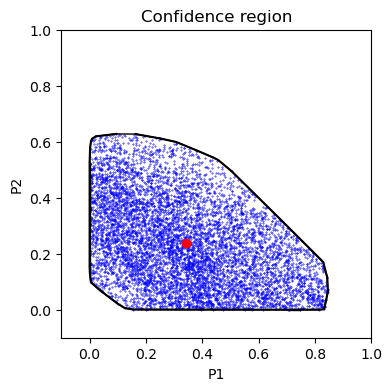

In [14]:
plots.draw_hull(Pcr, title = 'Confidence region')

To randomly take a subset of the solutions, with a sample size of 4 for source L, for example, we can do as shown below.

In [15]:
from pysasf import stats

In [16]:
combs,Ps = stats.randon_props_subsamples(arvorezinha, 'Y', 4)
print ("Suconjunto Ps de tamanho:", Ps.shape[0])

Suconjunto Ps de tamanho: 6480


To make the plot of the points and the 95% confidence region and save it to a file, we proceed as follows:

In [17]:
P_cr = cm.cm_feasebles(Ps)

In [18]:
plots.draw_hull(P_cr, savefig = True, title = 'Confidence region 95% whith Y size = 2')

Plot figure saved in: ../output/convex_hull.png


A figure will be saved in the output folder. If we want to create several plots with a sequence of reductions in the number of samples for a given source, we can proceed as follows.

In [19]:
for n in [2,4,8,12,16,20,24]:
    combs,Ps = stats.randon_props_subsamples(arvorezinha, 'Y', n)
    P_feas = cm.cm_feasebles(Ps)
    P_cr = stats.confidence_region(P_feas,space_dist='mahalanobis0')
    name = 'confidence_region_Y'+str(n)
    ax = plots.draw_hull(P_cr, savefig = True, filename = name)
    print('Saving figure named:', name)
    

Plot figure saved in: ../output/confidence_region_Y2.png
Saving figure named: confidence_region_Y2
Plot figure saved in: ../output/confidence_region_Y4.png
Saving figure named: confidence_region_Y4
Plot figure saved in: ../output/confidence_region_Y8.png
Saving figure named: confidence_region_Y8
Plot figure saved in: ../output/confidence_region_Y12.png
Saving figure named: confidence_region_Y12
Plot figure saved in: ../output/confidence_region_Y16.png
Saving figure named: confidence_region_Y16
Plot figure saved in: ../output/confidence_region_Y20.png
Saving figure named: confidence_region_Y20
Plot figure saved in: ../output/confidence_region_Y24.png
Saving figure named: confidence_region_Y24


### 3. Processing data from reductions and repetitions 

As a result of Clarke and Minella's article presents 
table and graphs of average values ​​for 50 repetitions taking
subsamples of different sizes drawn from each sample set.
A 95% confidence regions are calculated for each sample reduction and the proportions $P_1$ and $P_2$,
along with the standard deviations is calculated.

De full analysis can be repreduced and customized usin the routine `run_repetitions_and_reduction (basindata, source_key, list_of_reductions,repetitions=50)`. The results is saved in a `csv`file an can be stored and load later. A example is showed below.

In [20]:
tableY = cm.run_repetitions_and_reduction (arvorezinha, 'Y',[2,4,8,12,16,20,24])

Time for all runs: 49.353819608688354
Saving in C9E9L20Y24_Y-2-4-8-12-16-20-24.csv


In [21]:
tableL = cm.run_repetitions_and_reduction (arvorezinha, 'L',[2,4,8,12,16,20,])

Time for all runs: 45.833038091659546
Saving in C9E9L20Y24_L-2-4-8-12-16-20.csv


Finally the results can be ploted by columns setting the files and the names of columns to be ploted, like the example below.


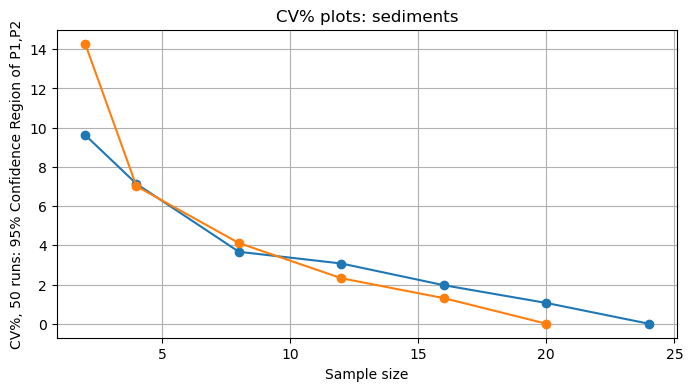

In [22]:
from pysasf import plots
files = [arvorezinha.output_folder+'/'+'C9E9L20Y24_Y-2-4-8-12-16-20-24.csv',
         arvorezinha.output_folder+'/'+'C9E9L20Y24_L-2-4-8-12-16-20.csv']

plots.plot_cm_outputs(files, 'nSamp', 'CV', savefig=False)